In [1]:
import sys
sys.path.append('../')

import cProfile
import time

import numpy as np
import torch as tc
import matplotlib.pyplot as plt

import objax
from BayesNewton import bayesnewton

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.rcgp import TemporalRCGP

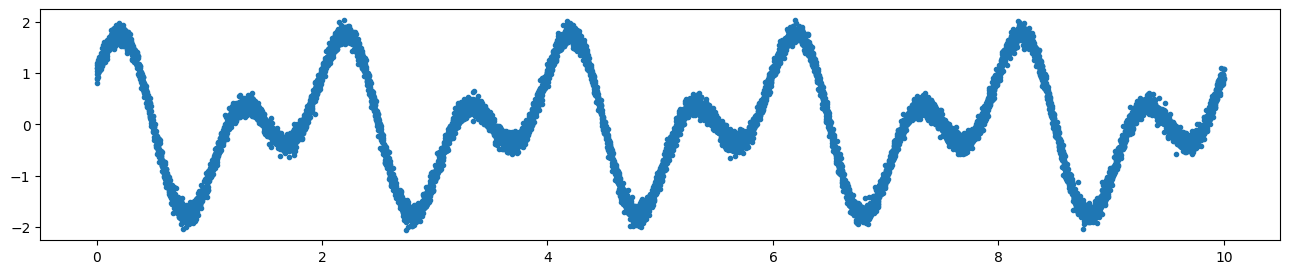

In [2]:
tc.manual_seed(42)  # For reproducibility
n_data_pts = 10000
ts = tc.linspace(0, 10, n_data_pts)
Ys = tc.cos(tc.pi * ts) + tc.sin(2 * tc.pi * ts) + tc.distributions.Normal(loc=0, scale=0.1).sample((len(ts), ))
plt.figure(figsize=(16,3))
plt.plot(ts, Ys, '.')

In [3]:
def bayes_newton_EP(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output:print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output: print("Negative Log Predictive Density: ")
    if return_output: print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


    if return_output: print("Prediction time (s) : ", t2 - t1)
    if return_output:print("Lengthscale : ", model.kernel.lengthscale)
    if return_output:print("Kernel Variance : ", model.kernel.variance)
    #print("Likelihood Variance : ", model.likelihood.variance)

    if return_output:
        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [13]:
bayes_newton_EP(obs_grid=ts.numpy(), obs=Ys.numpy(), return_output=False)

6.354105234146118

In [3]:
def matching():
    trcgp = TemporalRCGP(ts=ts.reshape(-1,1), Ys=Ys.reshape(-1,1))
    trcgp.activate_robustness(func="m_pred")
    trcgp.temporal_lengthscale = 0.1
    (tpreds_smooth, tstds_smooth, teff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = trcgp.forward() 

    rtgp = SpatioTemporalRCGP(ts=ts.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1))
    rtgp.activate_robustness(func='m_pred')
    rtgp.temporal_lengthscale=0.1
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward() 

    return (tpreds_smooth -preds_smooth).sum(), (tstds_smooth - stds_smooth).sum(), (teff -eff).sum()
matching()


(tensor(-0.0002, grad_fn=<SumBackward0>),
 tensor(-4.9055e-05, grad_fn=<SumBackward0>),
 tensor(8.9407e-06))

In [4]:
def test_speed():
    with tc.no_grad():
        t1 = time.time()
        rtgp = TemporalRCGP(ts=ts.reshape(-1,1), Ys=Ys.reshape(-1,1))
        rtgp.activate_robustness(func='m_pred')
        rtgp.temporal_lengthscale=0.1
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 

        t2 = time.time()
        return t2 - t1

test_speed()


1.5490891933441162

In [5]:
profiler = cProfile.run("""
test_speed()
""", sort='cumulative')

         742004 function calls (741975 primitive calls) in 1.644 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    1.645    0.411 base_events.py:1910(_run_once)
        1    0.000    0.000    1.644    1.644 {built-in method builtins.exec}
        1    0.000    0.000    1.644    1.644 <string>:1(<module>)
        1    0.000    0.000    1.644    1.644 834996500.py:1(test_speed)
        1    0.000    0.000    1.640    1.640 rcgp.py:402(forward)
        1    0.487    0.487    1.639    1.639 rcgp.py:334(filtsmooth)
    10000    0.176    0.000    0.807    0.000 rcgp.py:304(update_step)
    10000    0.025    0.000    0.253    0.000 rcgp.py:270(compute_weights)
    10000    0.102    0.000    0.201    0.000 rcgp.py:224(v)
    70004    0.021    0.000    0.186    0.000 _tensor.py:33(wrapped)
    10000    0.103    0.000    0.138    0.000 rcgp.py:10(IMQ_and_gradient)
    10001    0.137    0.000    0.137   